# Heat transfer simulations

In this task, we'll learn how to run a heat transfer simulation and couple it to H transport.

The governing equation for transient heat transfer is:

$$\rho \ C_p \frac{\partial T}{\partial t} = \nabla \cdot (\lambda \ \nabla T) + \dot{Q} $$

where $\rho$ is the density in kg/m3, $C_p$ is the heat capacity in J/kg, $\lambda$ is the thermal conductivity in W/m/K, and $\dot{Q}$ is the volumetric heat source in W/m3.

In steady state, this becomes:

$$\nabla \cdot (\lambda \ \nabla T) + \dot{Q} = 0$$

## 1D simulation

We'll start with a simple 1D simulation.

In [15]:
import festim as F
import numpy as np

model_1d = F.Simulation()

model_1d.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 1, num=1000)
)


model_1d.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False
    )

Since we want to run a heat transfer simulation, the thermal conductivity $\lambda$ in W/m/K has to be specified in the material.

> Note:
> 
> Here we have to specify diffusion parameters even though we don't need it since we're focussing on heat transfer

In [16]:
mat = F.Material(id=1, D_0=1, E_D=0.2, thermal_cond=2)
model_1d.materials = mat

To use the temperature from a Heat Transfer simulation instead of a prescribed temperature, we are using the `festim.HeatTransferProblem` class.

Here we want to run a steady state heat transfer simulation (_ie_ `transient=False`).

> Note
> 
> If we wanted to run a transient heat transfer simulation, then we would have to provide $C_p$ and $\rho$ in the material definition

The boundary conditions of our heat transfer problem are:

- $ T = 300 \ \mathrm{K}$    on the left surface

- $-\lambda \nabla T \cdot n = h (T - T_\mathrm{ext})$ on the right surface with $h=1$ W/m2/K and $T_\mathrm{ext} = 650  \ \mathrm{K}$

The boundary conditions for the heat transfer problem are given by specifying `field="T"` (instead of `field=0` for mobile hydrogen).

In [17]:
model_1d.T = F.HeatTransferProblem(transient=False)


model_1d.boundary_conditions = [
    F.DirichletBC(value=300, field="T", surfaces=1),
    F.ConvectiveFlux(h_coeff=1, T_ext=650, surfaces=2)
]


We will also set a volumetric heat source $\dot{Q} = 1000 $ W/m3. Similarily, we simply specify `field="T"`.

In [18]:
model_1d.sources = [F.Source(value=1000, volume=1, field="T")]

Let's run the simulation and plot the temperature profile.

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


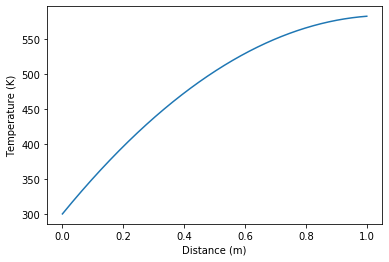

In [19]:
model_1d.initialise()
model_1d.run()

from fenics import plot
import matplotlib.pyplot as plt

plot(model_1d.T.T)
plt.ylabel("Temperature (K)")
plt.xlabel("Distance (m)")
plt.show()

## 2D simulation

Let's move on to a more complex model in 2D.

It is possible to set a temperature-dependent thermal conductivity by creating a function and passing it to the `thermal_cond` argument.

Here, $\lambda = 3 + 0.1\ T$

In [20]:
import festim as F

model_2d = F.Simulation()

def thermal_cond_function(T):
    return 3 + 0.1*T

mat = F.Material(
    id=1,
    D_0=4.1e-7,
    E_D=0.39,
    thermal_cond=thermal_cond_function
    )
model_2d.materials = F.Materials([mat])

We create a simple mesh with FEniCS and mark its subdomains (surfaces and volume).

For more information on FEniCS meshes, please visit [the mesh demo](https://fenicsproject.org/olddocs/dolfin/latest/python/demos/built-in-meshes/demo_built-in-meshes.py.html) and the [subdomains demo](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html).

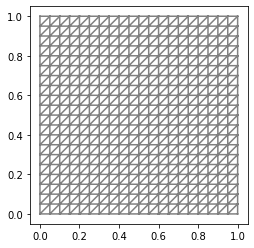

In [21]:
from fenics import UnitSquareMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = UnitSquareMesh(nx, ny)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 1, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 1, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

left_id = 1
top_and_bottom_id = 2
right_id = 3
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_and_bottom_id)
bottom_surface.mark(surface_markers, top_and_bottom_id)

plot(mesh_fenics)

# creating mesh with festim
model_2d.mesh = F.Mesh(
    mesh=mesh_fenics,
    volume_markers=volume_markers,
    surface_markers=surface_markers
)


Let's add a trap to the H transport model.

In [22]:
trap = F.Trap(
    k_0=3.8e-17,
    E_k=0.39,
    p_0=8.4e12,
    E_p=0.9,
    density=1e25,
    materials=mat
    )
model_2d.traps = F.Traps([trap])

For the heat transfer model's source and boundary conditions, we'll make use of sympy to create spatially dependent values. Because why not.

In [23]:
import sympy as sp

model_2d.T = F.HeatTransferProblem(transient=False)

model_2d.sources = [
    F.Source(
        value=1 + 0.1*F.x,
        volume=1,
        field="T"
    )]

heat_transfer_bcs = [
    F.DirichletBC(
        surfaces=1,
        value=350 + 20*sp.cos(F.x)*sp.sin(F.y),
        field="T"
    ),
    F.ConvectiveFlux(
        surfaces=2,
        h_coeff=100*F.x,
        T_ext=300 + 3*F.y
    ),
    F.FluxBC(
        surfaces=3,
        value=10 + 3*sp.cos(F.x) + sp.sin(F.y),
        field="T"
    )
]

We do the same for the H transport boundary condition, and add everything to `model_2d.boundary_conditions`

In [24]:
tritium_transport_bcs = [
    F.DirichletBC(
        surfaces=1,
        value=1e19*(1 + sp.cos(F.y)),
        field=0
    ),

]

model_2d.boundary_conditions = heat_transfer_bcs + tritium_transport_bcs

Finally, let's export our 2D fields to XDMF.

In [25]:
export_folder = "task07"
model_2d.exports = F.Exports([
    F.XDMFExport("solute", folder=export_folder),
    F.XDMFExport("retention", folder=export_folder),
    F.XDMFExport("T", folder=export_folder)
    ])

Final settings, and we run the simulation:

In [26]:
model_2d.settings = F.Settings(
    transient=False,
    absolute_tolerance=1e-09,
    relative_tolerance=1e-09,
)

model_2d.initialise()
model_2d.run()

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.10 s


The XDMF files can be read back using the `load_xdmf` function below.

If the fields are 1D or 2D, they can be plotted with matplotlib using `fenics.plot()`.
This is useful to produce high quality plots for publication.

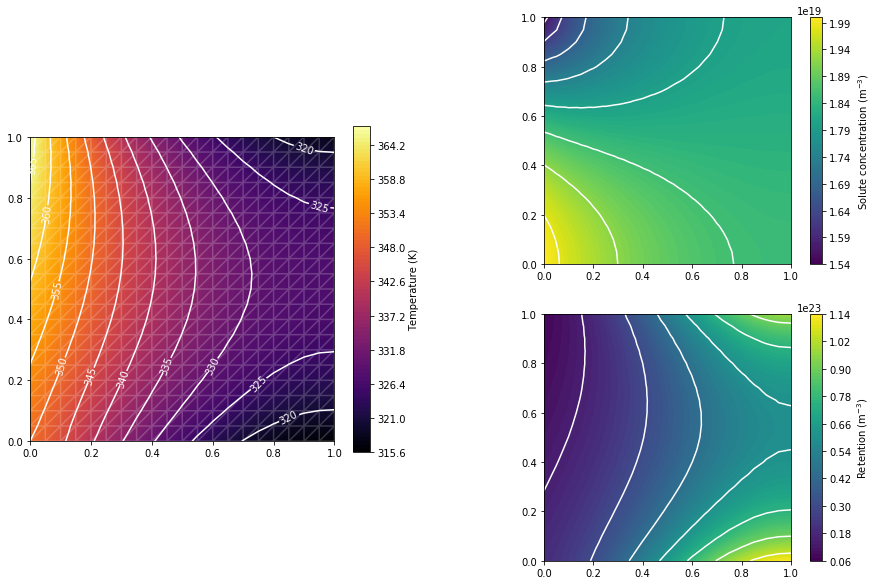

In [27]:
from fenics import XDMFFile, FunctionSpace, Function, plot


def load_xdmf(mesh, filename, field, element="CG", counter=-1):
    """Loads a XDMF file and store its content to a fenics.Function

    Args:
        mesh (fenics.mesh): the mesh of the function
        filename (str): the XDMF filename
        field (str): the name of the field in the XDMF file
        element (str, optional): Finite element of the function.
            Defaults to "CG".
        counter (int, optional): timestep in the file, -1 is the
            last timestep. Defaults to -1.

    Returns:
        fenics.Function: the content of the XDMF file as a Function
    """

    V = FunctionSpace(mesh, element, 1)
    u = Function(V)

    XDMFFile(filename).read_checkpoint(u, field, counter)
    return u


# get the mesh from the model
mesh = model_2d.mesh.mesh

# read the solutions
T = load_xdmf(mesh, export_folder + "/temperature.xdmf", "temperature")
solute = load_xdmf(mesh, export_folder + "/mobile_concentration.xdmf", "mobile_concentration", element="DG")
retention = load_xdmf(mesh, export_folder + "/retention.xdmf", "retention")

# plot
plt.figure(figsize=(15, 10))

# plot temperature
plt.subplot(1, 2, 1)
CF = plot(T, cmap="inferno", levels=100)
plot(mesh, color="white", alpha=0.2)  # overlay the mesh
CS = plot(T, mode="contour", colors="white", levels=10)
CL = plt.clabel(CS, inline=True, fmt='%.f')
CB = plt.colorbar(CF, shrink=0.6, label="Temperature (K)")

# plot mobile concentration
plt.subplot(2, 2, 2)
CF = plot(solute, levels=100)
CS = plot(solute, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Solute concentration (m$^{-3}$)")

# plot retention
plt.subplot(2, 2, 4)
CF = plot(retention, levels=100)
CS = plot(retention, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Retention (m$^{-3}$)")

Looking at the retention field, we can see that the retention is higher in cold regions (bottom and top right).

Below, we show how to trace profiles by evaluating the `fenics.Function` variable `T` at different coordinates.

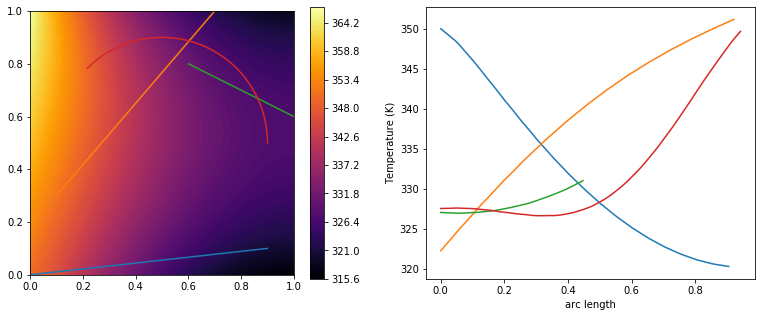

In [28]:
import numpy as np

def compute_arc_length(xs, ys):
    """Computes the arc length of x,y points based
    on x and y arrays
    """
    points = np.vstack((xs, ys)).T
    distance = np.linalg.norm(points[1:] - points[:-1], axis=1)
    arc_length = np.insert(np.cumsum(distance), 0, [0.0])
    return arc_length

# plot
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# plot the retention
plt.sca(axs[0])
CF = plot(T, cmap="inferno", levels=100)
plt.colorbar(CF)


# plot profiles
start_points = [(0, 0), (0.7, 1), (1, 0.6)]
end_points = [(0.9, 0.10), (0.1, 0.3), (0.6, 0.8)]

for start_point, end_point in zip(start_points, end_points):
    # compute the profile
    points_x = np.linspace(start_point[0], end_point[0], num=100)
    points_y = np.linspace(start_point[1], end_point[1], num=100)
    temp_profile = [T(x, y) for x, y in zip(points_x, points_y)]

    # plot
    plt.sca(axs[0])
    l, = plt.plot(points_x, points_y)
    plt.sca(axs[1])
    plt.plot(compute_arc_length(points_x, points_y), temp_profile, color=l.get_color())

# circular profile
angles = np.linspace(0, 3/4*np.pi, num=100)
radius = 0.4
points_x = 1/2 + radius*np.cos(angles)
points_y = 1/2 + radius*np.sin(angles)

temp_profile = [T(x, y) for x, y in zip(points_x, points_y)]

plt.sca(axs[0])
plt.plot(points_x, points_y, color="tab:red")
plt.sca(axs[1])
plt.plot(compute_arc_length(points_x, points_y), temp_profile, color="tab:red")


axs[1].set_xlabel("arc length")
axs[1].set_ylabel("Temperature (K)")
plt.show()

## Task

Run the 1D model with new thermal conductivities: 2, 3, 4, 5, 6 W/m/K.

How is the temperature field affected?
Try and plot all temperature fields on the same plot.

> 💡Tip:
> 
> You can change the thermal conductivity of the material with:
> ```python
> mat.thermal_cond = 3
> ```


<details>
<summary>Solution</summary>
<br>

```python
from fenics import plot
import matplotlib.pyplot as plt

# for loop
for thermal_cond in [2, 3, 4, 5, 6]:
    mat.thermal_cond = thermal_cond  # modify the material's thermal conductivity

    model_1d.initialise()  # reinitialise the model
    model_1d.run()  # run the model

    plot(model_1d.T.T, label=r"$\lambda = $" + f"{thermal_cond}")  # plot the temp profile

plt.ylabel("Temperature (K)")
plt.xlabel("Distance (m)")
plt.legend()
plt.show()
```

![image](https://github.com/RemDelaporteMathurin/FESTIM-workshop/assets/40028739/6095bd1e-e364-4b65-9cc6-1220a3f091f9)

As the thermal conductivity increases, it is easier to dissipate heat, therefore the temperature decreases.

</details>